In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold 
from sklearn import svm
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option('display.max_columns', None)
churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [4]:
churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'],errors='coerce')
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


In [5]:
churn.isnull().sum().sort_values(ascending = False)/len(churn)*100

TotalCharges        0.156183
Churn               0.000000
OnlineSecurity      0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
customerID          0.000000
dtype: float64

In [6]:
churn['TotalCharges'].fillna(value = churn['TotalCharges'].median(), inplace=True)
churn['TotalCharges'].isnull().sum()

0

In [7]:
converttoBinary={
    'Yes' : 1,
    'No' : 0,
    'No internet service' : 0,
    'No phone service' : 0
}

replaceFeatureVal = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn', 'OnlineSecurity', 
                    'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for i in replaceFeatureVal:
    churn[i] = churn[i].map(converttoBinary)

In [8]:
churn['MultipleLines'] = np.where(churn.MultipleLines == 'Yes', 1, 0)
churn['InternetDSL'] = np.where(churn.InternetService == 'DSL', 1, 0)
churn['InternetFiber'] = np.where(churn.InternetService == 'Fiber optic', 1, 0)
churn['Female'] = np.where(churn.gender == 'Female', 1, 0)
churn['OneYrContract'] = np.where(churn.Contract == 'One year', 1, 0)
churn['TwoYrContract'] = np.where(churn.Contract == 'Two year', 1, 0)

In [9]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetDSL,InternetFiber,Female,OneYrContract,TwoYrContract
0,7590-VHVEG,Female,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0,1,0,1,0,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0,1,0,0,1,0
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,1,0,0,0,0
3,7795-CFOCW,Male,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,0,0,1,0
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1,0,1,1,0,0


In [10]:
x = churn.drop(['customerID','gender','InternetService','Contract','PaymentMethod','Churn'], axis = 1)
y = churn['Churn']

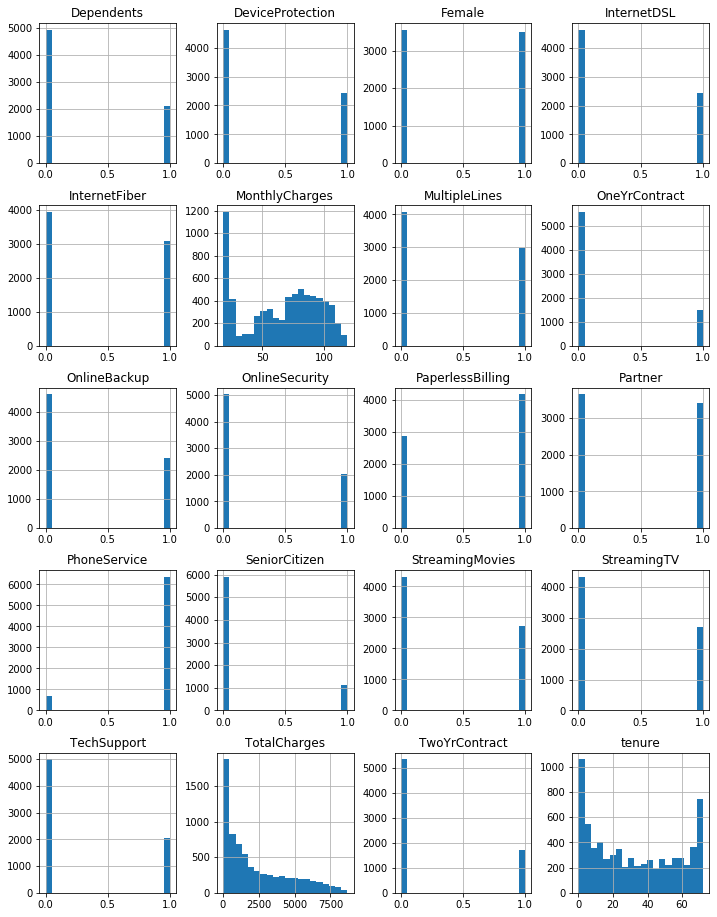

In [11]:
x.hist(bins = 20 , figsize= (12,16));

Text(0.5, 1, 'Variable Correlation')

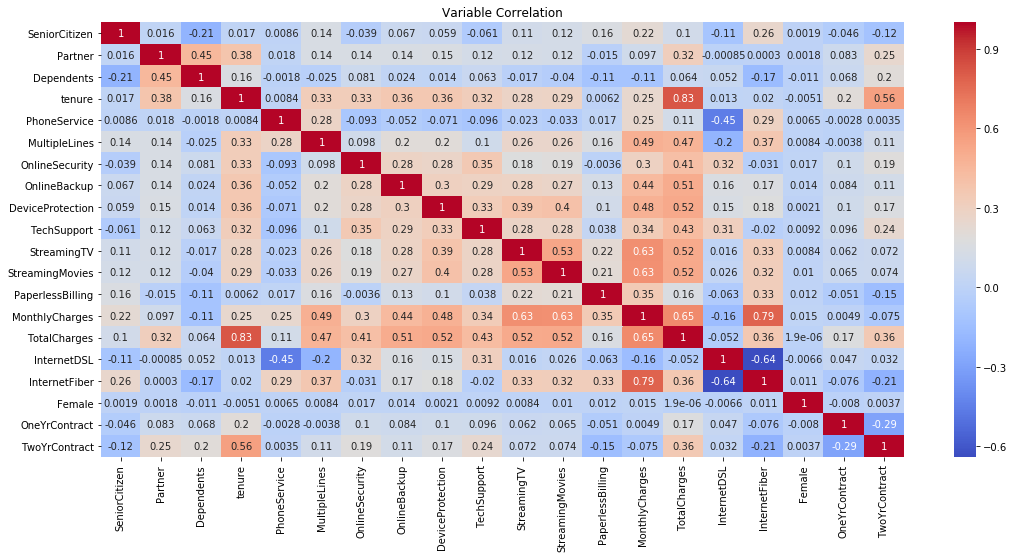

In [12]:
plt.figure(figsize=(18,8))
sns.heatmap(x.corr(),cmap = 'coolwarm', annot=True)
plt.title('Variable Correlation')

In [13]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
tenure              7043 non-null int64
PhoneService        7043 non-null int64
MultipleLines       7043 non-null int32
OnlineSecurity      7043 non-null int64
OnlineBackup        7043 non-null int64
DeviceProtection    7043 non-null int64
TechSupport         7043 non-null int64
StreamingTV         7043 non-null int64
StreamingMovies     7043 non-null int64
PaperlessBilling    7043 non-null int64
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
InternetDSL         7043 non-null int32
InternetFiber       7043 non-null int32
Female              7043 non-null int32
OneYrContract       7043 non-null int32
TwoYrContract       7043 non-null int32
dtypes: float64(2), int32(6), int64(12)
memory usage: 935.5 KB


In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.30, random_state=123)

In [ ]:
linear_svc = svm.SVC(kernel='linear')
val_mse = []
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    linear_svc.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_pred = linear_svc.predict(X_train.iloc[val_index])
    val_mse.append(mean_squared_error(y_train.iloc[val_index], y_pred))
sum(val_mse)/len(val_mse)